Adding solar system object (SSO) metric capabilities to [MAF](https://confluence.lsstcorp.org/display/SIM/MAF+documentation) moves far enough beyond the current concepts of slicers + metrics in MAF that it seems worthwhile to prototype the functionality required, test the best approaches, and then see how we should map this back into classes for MAF. 

The general concept in MAF (for stationary objects) is: 
* read the pointing history from the opsim sqlite database
* determine how to subdivide the pointing history appropriately for a desired metric measurement + use the appropriate `slicer` to do so
* iterate over the `slicer` and apply a `metric` (python class which makes a measurement on a given data slice) at each slice|
* consolidate the metric results at each slicepoint, as appropriate given the slicer (i.e. make a skymap, etc.)

For moving objects, we have additional steps and instead of the metric being applied per "subdivision of the pointing history" (per RA/Dec pointing, for example), we probably want to think of the metric being applied "per SSO". 
So the steps could be:
* read the orbital parameters and Hmag for each SSO
* read the pointing history from the opsim sqlite database
* determine when each individual object would be detected and what its magnitude would be in each detection (potentially, only record observations where the detection is > 5sigma??)
* apply metric based on observations
*  .. additional wrinkles: because this is slow (per object), we are also interested in (a) saving the pointing history for all objects, potentially also saving steps needed to create this pointing history for different opsim runs, and (b) allowing each object to be cloned to a variety of different H mags (equivalent to cloning over the size distribution, so that each single orbital parameter set represents a range of different objects). 

The 'generation of observations' steps here are joined in a single python class, 'moObs'. 

---

In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import repeat
from scipy import interpolate

import pandas as pd
import pyoorb as oo

import lsst.sims.photUtils.Bandpass as Bandpass
import lsst.sims.photUtils.Sed as Sed

Get the pointing history information from the opsim sqlite output.

In [2]:
from lsst.sims.maf.db import OpsimDatabase
from lsst.sims.utils import haversine

In [3]:
dbAddress = 'enigma_1189_sqlite.db'
ops = OpsimDatabase(dbAddress)

In [4]:
dbcols = ['expMJD', 'night', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 
          'finSeeing', 'fiveSigmaDepth', 'visitExpTime']
simdata = ops.fetchMetricData(dbcols, sqlconstraint='')
print simdata.dtype.names

('obsHistID', 'expMJD', 'night', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'finSeeing', 'fiveSigmaDepth', 'visitExpTime')


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression '' should be explicitly declared as text('') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


---
Read the moving object orbital information. Since the data from different moving object orbit files can have different keywords for the same values, or even need converting from Keplerian to Cometary orbits, we'll do some additional gymnastics to 'regularize' the output orbit array.

In [5]:
def _updateColMap(colMap, outCol, alternativeNames, ssoCols):
    for a in alternativeNames:
        if a in ssoCols:
            colMap[outCol] = a
    return colMap

def readOrbits(orbitfile='pha20141031.des'):
    """
    Read the orbits from file 'orbitfile', returning a numpy structured array with the columns:
    'objID q e inc node argPeri tPeri epoch H g a meanAnom'
    """
    orbits = pd.read_table(orbitfile, sep='\s*', engine='python')
    # Normalize the column names, as different inputs tend to have some commonly-different names. 
    ssoCols = orbits.columns.values.tolist()
    nSso = len(orbits)
    outCols = ['objId', 'q', 'e', 'inc', 'node', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'a', 'meanAnom']
    # Create mapping between column names read from disk and desired column names.
    colMap = {}
    for o in outCols:
        if o in ssoCols:
            colMap[o] = o
        else:
            # Try to find corresponding value
            if o == 'objId':
                alternatives = ['!!ObjID','objid', '!!OID']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'inc':
                alternatives = ['i']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'node':
                alternatives = ['BigOmega', 'Omega/node', 'Omega']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'argPeri':
                alternatives = ['argperi', 'omega/argperi']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'tPeri':
                alternatives = ['t_p', 'timeperi']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'epoch':
                alternatives = ['t_0']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'H':
                alternatives = ['magH', 'magHv', 'Hv']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'g':
                alternatives = ['phaseV', 'phase', 'gV']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'a':
                alternatives = ['semimajor']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'meanAnom':
                alternative = ['meanAnomaly', 'meananomaly', 'M']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
                
    # Add the columns we can generate. 
    if 'objId' not in colMap:
        orbids = np.arange(0, nSso, 1)
    else:
        orbids = orbits[colMap['objId']]
    if 'H' not in colMap:
        Hval = np.zeros(nSso) + 20.0
    else:
        Hval = orbits[colMap['H']]
    if 'g' not in colMap:
        gval = np.zeros(nSso) + 0.15
    else:
        gval = orbits[colMap['g']]
    
    # And some columns that can be converted from different orbit types.
    if 'a' not in colMap:
        aval = orbits[colMap['q']] / (1 + orbits[colMap['e']])
    else:
        aval = orbits[colMap['a']]
    period = np.sqrt(aval**3)
    if 'meanAnom' not in colMap:
        meanAnomval = 360.0*(orbits[colMap['epoch']] - orbits[colMap['tPeri']]) / (period*365.25)
    else:
        meanAnomval = orbits[colMap['meanAnom']]
    if 'q' not in colMap:
        qval = orbits[colMap['a']] * (1 - orbits[colMap['e']])
    else:
        qval = orbits[colMap['q']]
    if 'tPeri' not in colMap:
        tPerival = orbits[colMap['epoch']] - (orbits[colMap['meanAnom']]/360.0) * (period*365.25)
    else:
        tPerival = orbits[colMap['tPeri']]
        
    # Put it all together and turn it into a numpy array. 
    orbits = np.rec.fromarrays([orbids, qval, orbits[colMap['e']], orbits[colMap['inc']],
                                 orbits[colMap['node']], orbits[colMap['argPeri']], tPerival,
                                 orbits[colMap['epoch']], Hval, gval, aval, meanAnomval], 
                                names = outCols)
    return orbits

In [6]:
orbitfile = 'pha20141031.des'
orbits = readOrbits(orbitfile)

In [7]:
print orbits.dtype.names
print len(orbits), orbits[0]

('objId', 'q', 'e', 'inc', 'node', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'a', 'meanAnom')
1510 (0, 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 49353.16, 20.0, 0.15, 0.1020948712242672, 7927.89962516944)


Now we have some options to test. It's too expensive to calculate ephemerides for every object at the time of every opsim pointing, so we want to calculate positions on a coarse grid of times - let's start with calculating the positions every 2 hours for PHAs.  There are a few options for doing this: 
* (1) We could calculate the rough positions using [OpenOrb](https://code.google.com/p/oorb/wiki/OpenOrb) directly at the command line, for the full ten years. This is is efficient because it calculates the positions for all objects at once, meaning we only have to calculate things like the positions of the planets and Earth once for each time. A test on my laptop created a 10 year 2-hr grid of ephemerides in about 2 hours, producing a 42GB output file. The problems here are that you have to keep a fairly large output file (not something you'd like to read into memory as-is) and that the contents of the file are not in the order that we'd like (ordered by time, then object). I'll come back to this if the approaches below don't work out.
* (2) We could calculate the rough positions using the python bindings to OpenOrb, for each object over the full ten years, then calculate the actual observations matching opsim pointings, then write to disk. This is less efficient because the calculation of the Earth and planets' positions are repeated, but will be tested below. 
* (3) We could calculate the rough positions using the python bindings to OpenOrb, but do it for all objects at once .. since the full results won't fit in memory, we could do it month-by-month (or some other time step). This is efficient only if we can also propagate and save the orbits at each interval; otherwise we have to re-propagate the orbits over the gap between their epoch and the start of observations every time. I'm not entirely sure the propagation routines have working python bindings, but will test below. This is a nice approach, although it doesn't quite fit into the "per object" concept as cleanly. 

Testing ephemeris generation, along the style of option (2) above. <br>

>Try generating SPK files with SPICE (http://naif.jpl.nasa.gov/naif/toolkit_C_MacIntel_OSX_AppleC_64bit.html).. basically just generating interpolation with chebychev instead of polynomial! But SPICE does automatic generation of what size window/how many coefficient. 

... and also, see how big a gap in the coarse grid I can get (1 day?)

Because pyoorb is a python interface to a Fortran program (OpenOrb), written very simply with f2py, we have to do some awkwardness with array-rearranging.

In [8]:
def setTimes(timestep=1., nyears=1., timestart=49353.):
    # Extend times beyond first/last observation, so that interpolation doesn't fail
    timestart = timestart - timestep
    timeend = timestart + 365 * nyears + timestep 
    times = np.arange(timestart, timeend + timestep/2.0, timestep)
    # For pyoorb, we need to tag times with timescales;
    # 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
    ephTimes = np.array(zip(times, repeat(4, len(times))), dtype='double', order='F')
    return ephTimes

In [9]:
nyears = 10
ephTimes = setTimes(timestep=2./24., nyears=nyears)

Set up pyoorb (reads in JPL ephemerides for major planets, etc.). 

In [10]:
oo.pyoorb.oorb_init(ephemeris_fname="")

3

Python oorb element format: 
        # Translate orbital elements into array that pyoorb will like.
        # PyOrb wants ::
        # 0: orbitId  (cannot be a string)
        # 1 - 6: orbital elements, using radians for angles
        # 7: element type code, where 2 = cometary - means timescale is TT, too
        # 8: epoch
        # 9: timescale for the epoch; 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
        # 10: magHv
        # 11: G
so we have to do a little translating from the orbits DataFrame to the elements we want in this array. 

In [11]:
def packOorbElem(sso):
    """
    Convert numpy structured array of orbital elements into the array OpenOrb needs as input.
    'sso' can be the orbital elements of a single object or of multiple objects.
    To normalize the column names to those expected here, read in data using 'readOrbits'.
    """
    if len(sso.shape) == 0:
        # Passed a single SSO
        nSso = 0
        sso0 = sso
        elem_type = 2
        epoch_type = 3
    else:
        nSso = len(sso)
        sso0 = sso[0]        
        elem_type = np.zeros(nSso) + 2
        epoch_type = np.zeros(nSso) + 3
    # Check on orbit id type - pyoorb needs numbers not strings.
    if (isinstance(sso0['objId'], float) or isinstance(sso0['objId'], int)):
        orbids = sso['objId']
    else:
        if nSso == 0:
            orbids = 0
        else:
            orbids = np.arange(0, nSso, 1)
    # Convert to format for pyoorb, INCLUDING converting inclination, node, argperi to RADIANS
    oorbArray = np.column_stack((orbids, sso['q'], sso['e'], np.radians(sso['inc']),
                                 np.radians(sso['node']), np.radians(sso['argPeri']),
                                 sso['tPeri'], elem_type, sso['epoch'], epoch_type, 
                                 sso['H'], sso['g']))                                            
    return oorbArray

In [12]:
%%timeit
print nyears, ' (years of ephemerides)'
for sso in orbits[0:1]:
    print sso
    oorbelems = packOorbElem(sso)
    oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)

10  (years of ephemerides)
(0, 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 49353.16, 20.0, 0.15, 0.1020948712242672, 7927.89962516944)
10  (years of ephemerides)
(0, 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 49353.16, 20.0, 0.15, 0.1020948712242672, 7927.89962516944)
10  (years of ephemerides)
(0, 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 49353.16, 20.0, 0.15, 0.1020948712242672, 7927.89962516944)
10  (years of ephemerides)
(0, 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 49353.16, 20.0, 0.15, 0.1020948712242672, 7927.89962516944)
1 loops, best of 3: 8.04 s per loop


Just about 8 seconds per object to calculate the coarse grid over 10 years (for 2 hour timesteps). 1 second for 1 day timesteps. For many simulations, I think we'd have on the order of 1000-2000 objects = 2.5 - 5 hours for this step, done like this.  I tested ephemeris generation separately of the numpy-array-reordering and the time was very similar, so most of the time is indeed going into pyoorb.

And also, more awkwardness with the ephems and elems arrays:

Python oorb ephem array format:
    #   [objid][time][ephemeris information @ that time]
    # 0 = distance (geocentric distance)
    # 1 = ra (deg)
    # 2 = dec (deg)
    # 3 = mag
    # 4 = ephem mjd
    # 5 = ephem mjd timescale
    # 6 = dra/dt (deg/day) sky motion
    # 7 = ddec/dt (deg/day) sky motion
    # 8 = phase angle (deg)
    # 9 = solar elongation angle (deg)
So usually we want to swap the axes at least, so that instead of all the ephemeris information @ a particular time being the accessible bit of information, we have all the RA values over time for a single object ('byObject') Alternatively, we may want all the RA values for all objects at one time. This is also an option, by setting 'byObject' to False.

In [13]:
def unpackEphs(oorbephems, byObject=True):
    """
    Given oorb ephemeris array (shape = object / times / eph@time),
    Return an array aranged with 
     columns = ['delta', 'ra', 'dec', 'mag', 'time', 'timescale', 'dradt', 'ddecdt', 'phase', 'solarelon']
     as the second
    grouped either by object (i.e. length of ra array == length of times) (default)
    or grouped by time (i.e. length of ra array == number of objects) (if byObject not true).
    """
    ephs = np.swapaxes(oorbephems, 2, 0)
    # oorbcols=['delta', 'ra', 'dec', 'magV', 'time', 'timescale', 'dradt', 'ddecdt', 'phase', 'solarelon']
    velocity = np.sqrt(ephs[6]**2 + ephs[7]**2)
    if byObject:
        ephs = np.swapaxes(ephs, 2, 1)
        velocity = np.swapaxes(velocity, 1, 0)
    # Create numpy structured array
    ephs = np.rec.fromarrays([ephs[0], ephs[1], ephs[2], ephs[3], ephs[4], 
                              ephs[6], ephs[7], ephs[8], ephs[9], velocity], 
                             names=['delta', 'ra', 'dec', 'magV', 'time', 'dradt', 
                                    'ddecdt', 'phase', 'solarelon','velocity'])
    return ephs

All right, let's test interpolating the coarse ephemerides to all the times in opsim. 

In [14]:
# Linear interpolation
def interpolateEphs(ephs, i=0):
    interpfuncs = {}
    for n in ephs.dtype.names:
        if n == 'time':
            continue
        interpfuncs[n] = interpolate.interp1d(ephs['time'][i], ephs[n][i], kind='linear', 
                                              assume_sorted=True, copy=False)
    return interpfuncs

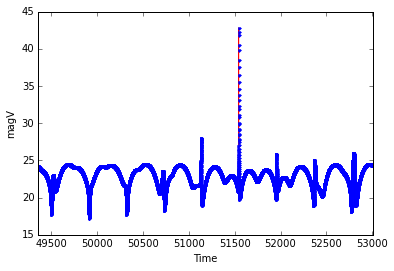

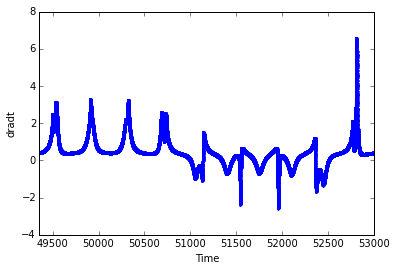

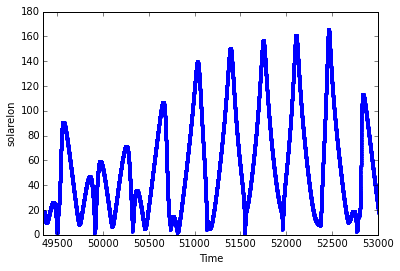

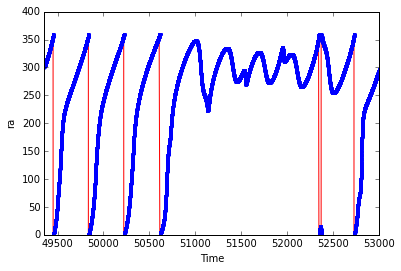

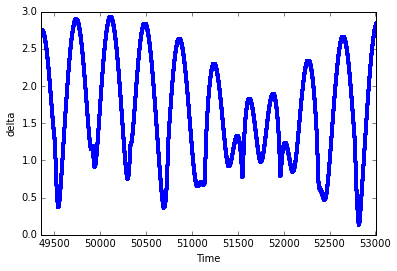

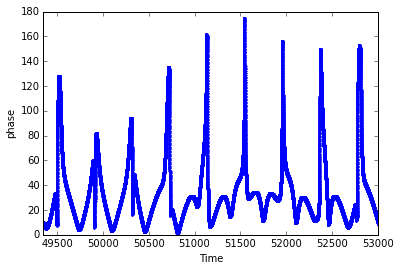

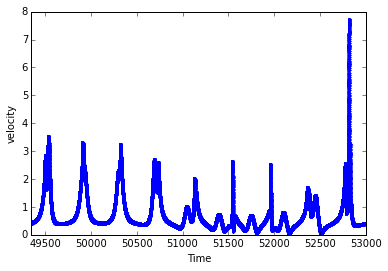

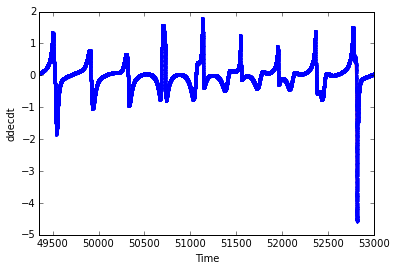

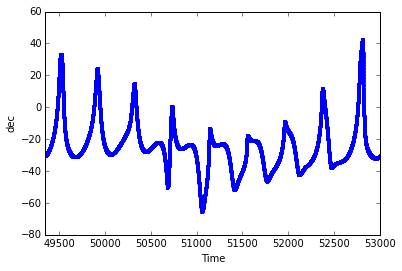

In [15]:
obstimes = simdata['expMJD']
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephems)
    interpfuncs = interpolateEphs(ephs)
    # Have a look.
    for n in interpfuncs:
        plt.figure()
        plt.plot(obstimes, interpfuncs[n](obstimes), 'r-')
        plt.plot(ephs['time'][0], ephs[n][0], 'b.')
        plt.xlim(obstimes[0], obstimes[-1])
        plt.xlabel('Time')
        plt.ylabel(n)

In [16]:
%%timeit
# Check the timing
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephems)
    interpfuncs = interpolateEphs(ephs)

1 loops, best of 3: 8.17 s per loop


Awesome. Still about 8s per object with the interpolation. (This would not be true if we did higher order than linear interpolation). <br>
Let's add the step of checking the positions against the opsim pointings, to determine when the object might actually have been seen.

Simple circular FOV:

In [17]:
def ssoInFov(interpfuncs, simdata, rFov=np.radians(1.75), raCol='fieldRA', decCol='fieldDec'):
    """
    Return the indexes of the observations where the object could be seen.
    """
    raSso = np.radians(interpfuncs['ra'](simdata['expMJD']))
    decSso = np.radians(interpfuncs['dec'](simdata['expMJD']))
    sep = haversine(raSso, decSso, simdata[raCol], simdata[decCol])
    idxObs = np.where(sep<rFov)[0]
    return idxObs

Actual camera chipgaps:

In [18]:
# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import findChipName, observedFromICRS
from lsst.sims.catalogs.generation.db.ObservationMetaData import ObservationMetaData

mapper = LsstSimMapper()
camera = mapper.camera
epoch = 2000.0

In [19]:
def ssoInFovChip(interpfuncs, simdata, rFov=np.radians(1.75), raCol='fieldRA', decCol='fieldDec'):
    """
    Return the indexes of the observations where the object could be seen.
    """
    raSso = np.radians(interpfuncs['ra'](simdata['expMJD']))
    decSso = np.radians(interpfuncs['dec'](simdata['expMJD']))
    sep = haversine(raSso, decSso, simdata[raCol], simdata[decCol])
    idxObsRough = np.where(sep<rFov)[0]
    idxObs = []
    for idx in idxObsRough:
        mjd = simdata[idx]['expMJD']
        obs_metadata = ObservationMetaData(unrefractedRA=np.degrees(simdata[idx][raCol]),
                                           unrefractedDec=np.degrees(simdata[idx][decCol]),
                                           rotSkyPos=np.degrees(simdata[idx]['rotSkyPos']),
                                           mjd=simdata[idx]['expMJD'])
        raObj = np.radians(np.array([interpfuncs['ra'](simdata[idx]['expMJD'])]))
        decObj = np.radians(np.array([interpfuncs['dec'](simdata[idx]['expMJD'])]))
        raObj, decObj = observedFromICRS(raObj, decObj, obs_metadata=obs_metadata, epoch=epoch)
        chipNames = findChipName(ra=raObj,dec=decObj, epoch=epoch, camera=camera, obs_metadata=obs_metadata)
        if chipNames != [None]:
            idxObs.append(idx)
    idxObs = np.array(idxObs)
    return idxObs

So let's test adding in the check if the object is in the FOV and finding the properties of the object at those times.

In [20]:
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephems)
    interpfuncs = interpolateEphs(ephs)
    idxObs = ssoInFov(interpfuncs, simdata)
    #idxObs = ssoInFovChip(interpfuncs, simdata)
    tvis = simdata['expMJD'][idxObs]
    obs = np.recarray([len(tvis)], dtype=ephs.dtype)
    for n in interpfuncs:
        obs[n] = interpfuncs[n](tvis)
    obs['time'] = tvis        
    print len(idxObs)

501


448 with the chipgaps; 501 with the circular aperture for the first PHA. 

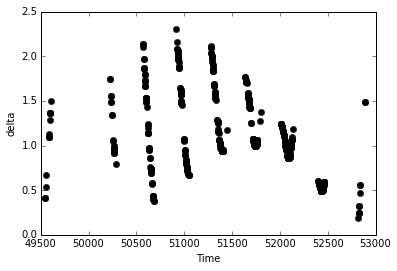

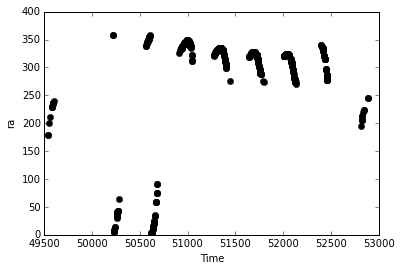

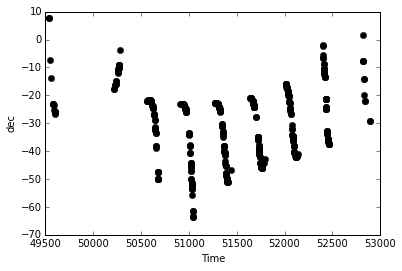

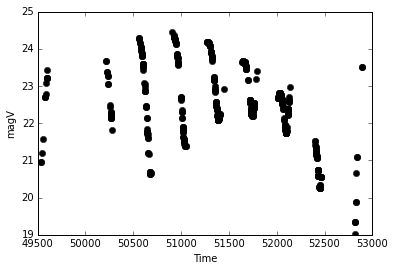

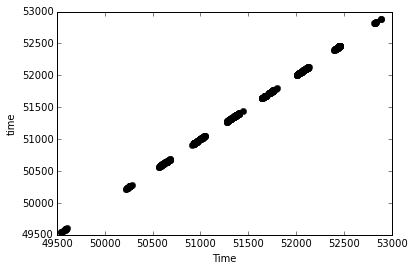

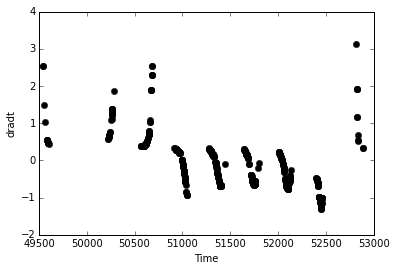

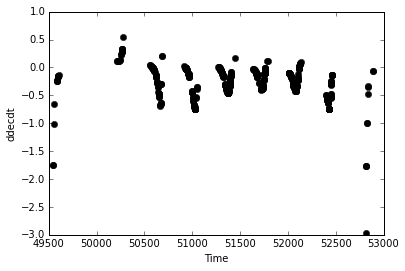

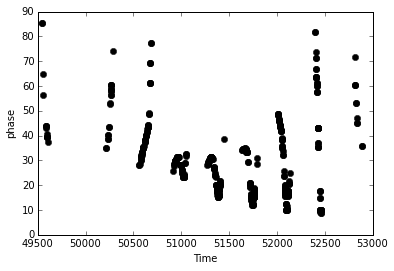

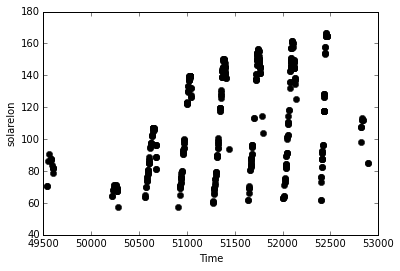

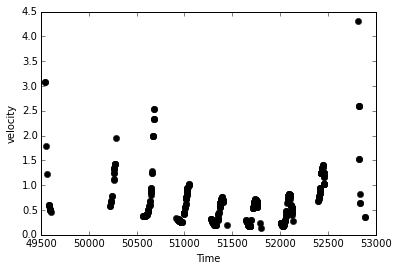

In [21]:
for n in obs.dtype.names:
    plt.figure()
    plt.plot(obs['time'], obs[n], 'ko')
    plt.xlabel('Time')
    plt.ylabel(n)

---
So we now can generate all of the observations of the object, including whether they're in the FOV with or without chipgaps. 

We still need to pull out the opsim data at each observation, and this is easiest when we still have the 'idxObs' list for each object. 

In order to get all of the info we need at each observation, we need to calculate the colors of all objects (to generate offsets between the standard magV and the filter used in each observation). 
We also have to calculate trailing losses and detection losses (see [Trailing Loss notebook](./Trailing%20Losses.ipynb)). 

In [22]:
def calcColors(sedname='C.dat'):
    # Calculate SSO colors. 
    filterdir = os.getenv('LSST_THROUGHPUTS_BASELINE')
    filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
    lsst ={}
    for f in filterlist:
        lsst[f] = Bandpass()
        lsst[f].readThroughput(os.path.join(filterdir, 'total_'+f+'.dat'))
    vband = Bandpass()
    vband.readThroughput('harris_V.dat')
    csed = Sed()
    csed.readSED_flambda(sedname)
    vmag = csed.calcMag(vband)
    dmags = {}
    for f in filterlist:
        dmags[f] = csed.calcMag(lsst[f]) - vmag
    return dmags

In [23]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
dmags = calcColors()
for f in filterlist:
    print f, dmags[f]
# Example:
print '---'
v = 20
for f in filterlist:
    print f, v+dmags[f]

u 1.6144033523
g 0.302320621737
r -0.172306859497
i -0.291351785733
z -0.298075537869
y -0.30256349639
---
u 21.6144033523
g 20.3023206217
r 19.8276931405
i 19.7086482143
z 19.7019244621
y 19.6974365036


Calculate the additional things we must write out to add to the simdata, and write these + the opsim and object ephemeride data out for each observation.

In [31]:
def joinObs(ephs, simdata, idxObs, sedname='C.dat', tol=1e-8, outfileName='out.txt', 
            seeingcol='finSeeing', expTime='visitExpTime'):
    """
    Call for each object; write out the observations of each object.
    """
    # calculate extra values (color, trailing loss, and detection loss terms)
    # Calculate color term. 
    dmagColor = np.zeros(len(idxObs), float)
    dmagDict = calcColors(sedname)
    filterlist = np.unique(simdata[idxObs]['filter'])
    for f in filterlist:
        if f not in dmagDict:
            raise UserWarning('Could not find filter %s in calculated colors!' %(f))
        match = np.where(simdata[idxObs]['filter'] == f)[0]
        dmagColor[match] = dmagDict[f]
    # Calculate trailing and detection loses. 
    pm_LHS = np.array([  4.04959668e-04,   1.54946862e-03,  -7.32311940e-02,
                         4.13138884e-01,  -2.13021674e-01,   1.03493047e+00], float)
    pt_LHS = np.array([ -4.65513418e-04,   8.86629066e-03,  -6.20199786e-02,
                        1.81920172e-01, 1.86156205e-02,   9.97466212e-01], float)
    x = ephs['velocity'] * simdata['visitExpTime'][idxObs] / simdata['finSeeing'][idxObs] / 24.0
    trail = 2.5*np.log10(np.polyval(pt_LHS, x))
    detect = 2.5*np.log10(np.polyval(pm_LHS, x))
    dmagTrailing = np.where(trail<0, 0, trail)
    dmagDetect = np.where(detect<0, 0, detect)
    
    # Turn into a recarray so it's easier below.
    dmags = np.rec.fromarrays([dmagColor, dmagTrailing, dmagDetect], 
                              names=['dmagColor', 'dmagTrailing', 'dmagDetect'])
    
    outCols = list(ephs.dtype.names) + list(simdata.dtype.names) + list(dmags.dtype.names)
    if not os.path.isfile(outfileName):
        outfile = open(outfileName, 'w')
        writestring = '#'
        for col in outCols:
            writestring += '%s ' %(col)
        print >> outfile, writestring
    else:
        outfile = open(outfileName, 'a')
    
    # Write results.
    for eph, simdat, dm in zip(ephs, simdata[idxObs], dmags):
        writestring = ''
        for col in ephs.dtype.names:
            writestring += '%s ' %(eph[col])
        for col in simdat.dtype.names:
            writestring += '%s ' %(simdat[col])
        for col in dm.dtype.names:
            writestring += '%s ' %(dm[col])
        print >> outfile, writestring
    outfile.close()

In [35]:
#%%timeit
for sso in orbits[0:3]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephems)
    interpfuncs = interpolateEphs(ephs)
    #idxObs = ssoInFov(interpfuncs, simdata)
    idxObs = ssoInFovChip(interpfuncs, simdata)
    tvis = simdata['expMJD'][idxObs]
    obs = np.recarray([len(tvis)], dtype=ephs.dtype)
    for n in interpfuncs:
        obs[n] = interpfuncs[n](tvis)
    obs['time'] = tvis        
    joinObs(obs, simdata, idxObs, outfileName='test.txt')

This required about 9 seconds for one object, 27s for 3 objects. Not too bad, especially as this gets us all the way to a complete output file. 

In [33]:
# Read the output file (ephemerides + opsim data + trailing/etc losses, for each observation) back in.
ssoObs = pd.read_table('test.txt', sep='\s*', engine='python')
ssoObs.head()

,#delta,ra,dec,magV,time,dradt,ddecdt,phase,solarelon,velocity,...,fieldRA,fieldDec,rotSkyPos,filter,finSeeing,fiveSigmaDepth,visitExpTime,dmagColor,dmagTrailing,dmagDetect
0,0.407790,178.554054,7.853689,20.969449,49540.020904,2.528608,-1.748578,85.525555,70.905501,3.074311,...,3.141593,0.128524,4.063771,i,1.030507,23.394825,30,-0.291352,0.613400,1.110046
1,0.407800,178.557465,7.851354,20.969423,49540.022240,2.528674,-1.748536,85.522353,70.908223,3.074342,...,3.087533,0.127822,4.095892,i,0.955558,23.445884,30,-0.291352,0.644290,1.166517
2,0.535783,200.570397,-7.461039,21.186844,49551.046682,1.480196,-1.019487,64.953147,86.517550,1.797316,...,3.499825,-0.114112,4.460240,z,1.015369,22.018934,30,-0.298076,0.399883,0.668842
3,0.664376,210.695185,-13.963565,21.584802,49558.967844,1.033271,-0.651569,56.410782,90.570445,1.221554,...,3.690123,-0.263957,3.592248,y,1.502535,20.617902,30,-0.302563,0.149971,0.170791
4,1.093462,228.996794,-23.126167,22.704031,49582.055036,0.558375,-0.236947,43.816952,87.775357,0.606572,...,3.984755,-0.396222,4.936402,z,0.628552,22.636733,30,-0.298076,0.191929,0.246530


From here, please hop to the [Prototype SSO Metrics notebook](./Prototype%20SSO%20Metrics.ipynb) to see what to do with this output! 

--- 
Just checking on the footprint code.

In [79]:
# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import findChipName, observedFromICRS
from lsst.sims.catalogs.generation.db.ObservationMetaData import ObservationMetaData

mapper = LsstSimMapper()
camera = mapper.camera
epoch = 2000.0

In [78]:
import lsst.sims.maf.db as db
opsdb = db.OpsimDatabase('enigma_1189_sqlite.db')
simdata = opsdb.fetchMetricData(['expMJD', 'fieldRA', 'fieldDec', 'rotSkyPos'], 'night=1')

/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression 'night=1' should be explicitly declared as text('night=1') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


In [80]:
import itertools
fieldra = 0.0
fielddec = 0.0
rotskypos = np.radians(45.0)
obs_metadata = ObservationMetaData(unrefractedRA = np.degrees(fieldra),
                                   unrefractedDec = np.degrees(fielddec),
                                   rotSkyPos = np.degrees(rotskypos),
                                   mjd = simdata[0]['expMJD'])
rai = np.arange(fieldra - np.radians(2), 
                fieldra + np.radians(2), np.radians(0.02))
deci = np.arange(fielddec - np.radians(2.5), 
                 fielddec + np.radians(2.5), np.radians(0.02))
ra = []
dec = []
for i in itertools.product(rai, deci):
    ra.append(i[0])
    dec.append(i[1])
ra = np.array(ra)
dec = np.array(dec)
ra, dec = observedFromICRS(ra, dec, obs_metadata=obs_metadata, epoch=epoch)
chipNames = findChipName(ra=ra, dec=dec, epoch=epoch, camera=camera, obs_metadata=obs_metadata)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

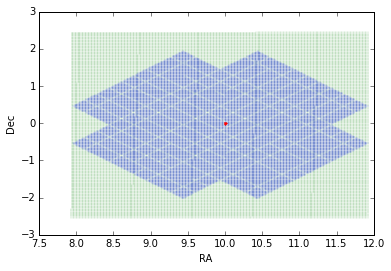

In [82]:
plt.figure()
condition = np.where(vis == 1)[0]
plt.plot((np.degrees(ra)+10)%360, np.degrees(dec), 'g.', markersize=0.2)
plt.plot((np.degrees(ra[condition])+10)%360, np.degrees(dec[condition]), 'b.', markersize=0.3)
plt.plot(np.degrees(fieldra)+10, np.degrees(fielddec), 'r.')
plt.xlabel('RA')
plt.ylabel('Dec')